In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
from rdkit import DataStructs
from sklearn.decomposition import PCA
import sqlite3

In [6]:
highs_a2a = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a2a.extend(df[-6_250:]["smi"])
    cnx.close()

In [7]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [8]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int_)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [9]:
chembl_ligands = pd.read_csv("../data/ligand_raw.tsv", sep="\t", usecols=["Smiles", "Target_ChEMBL_ID", "pChEMBL_Value"])

In [10]:
df = chembl_ligands.query("`Target_ChEMBL_ID` == 'CHEMBL251'").dropna(subset=["Smiles"]) # ["Smiles"].to_list()

In [11]:
df["is_active"] = df["pChEMBL_Value"] >= 6.5

In [12]:
fp_list = fp_list_from_smiles_list(df.Smiles)

  0%|          | 0/13004 [00:00<?, ?it/s]

In [13]:
drugex_base_fp_list = fp_list_from_smiles_list(highs_a2a)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [14]:
final_fp_list = fp_list + drugex_base_fp_list

In [15]:
hue_list = df.is_active.astype(int).to_list() + [2 for _ in range(len(highs_a2a))]

In [16]:
pca = PCA(n_components=2)
fcrds = pca.fit_transform(final_fp_list)
fcrds_df = pd.DataFrame(fcrds,columns=["PC_1","PC_2"])
fcrds_df['is_active'] = hue_list
fcrds_df.head()

,PC_1,PC_2,is_active
0,2.570279,-0.035017,0
1,2.618360,-0.020194,0
2,2.504599,0.189477,0
3,2.542250,0.217457,0
4,2.640804,0.277450,0


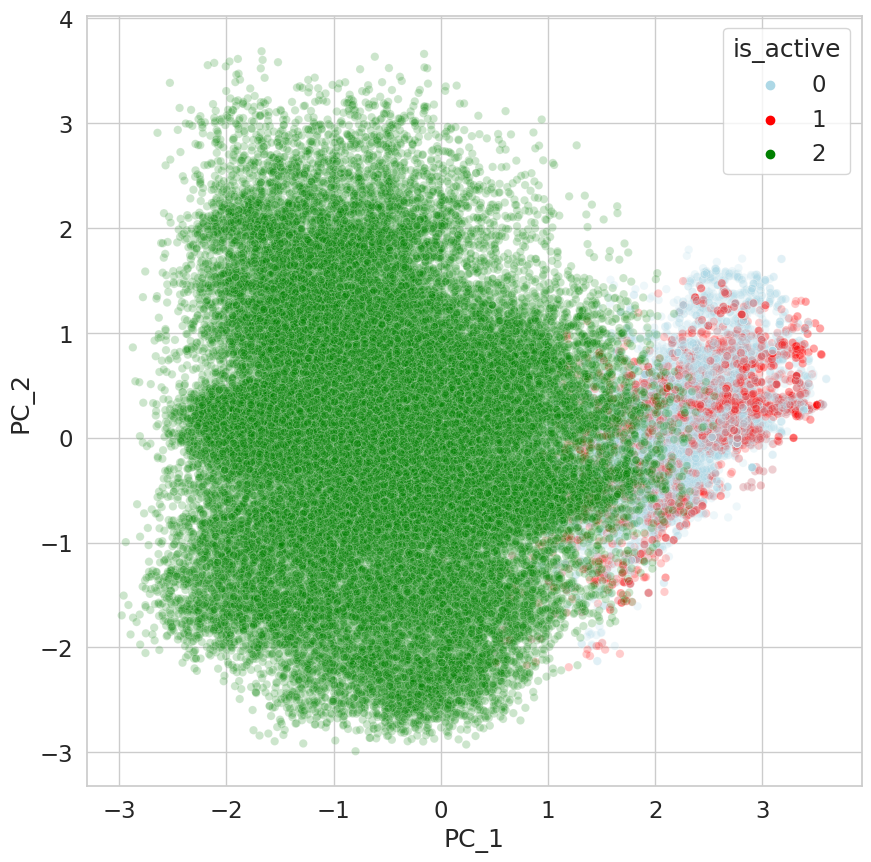

In [17]:
fax = sns.scatterplot(data=fcrds_df,x="PC_1",y="PC_2",hue="is_active",palette={0:'lightblue',1:'red',2:'green'}, alpha=0.2)

In [18]:
pca = PCA(n_components=50)
fcrds = pca.fit_transform(final_fp_list) 

In [19]:
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(fcrds)

/home/julius/miniconda3/envs/gflownet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/julius/miniconda3/envs/gflownet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 18min 10s, sys: 18.6 s, total: 18min 29s
Wall time: 2min 12s


In [20]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['is_active'] = hue_list

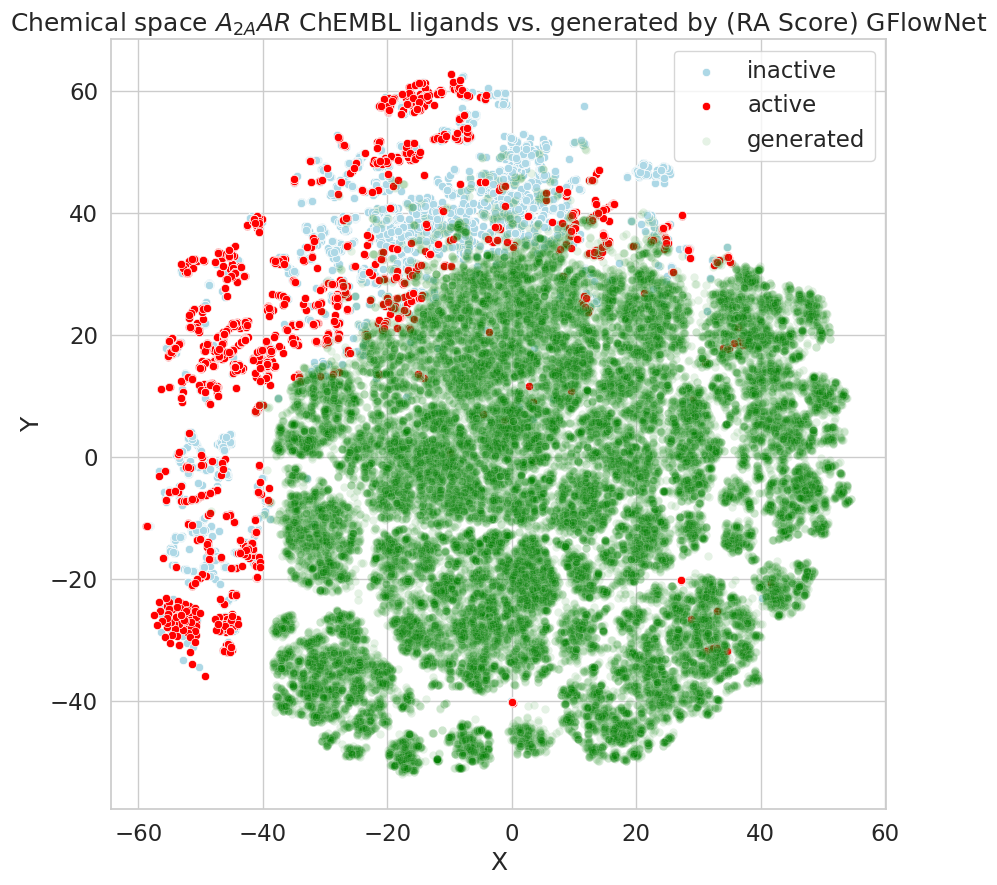

In [25]:
ax = sns.scatterplot(data=tsne_df.query("is_active == 0"),x="X",y="Y",color='lightblue')
ax = sns.scatterplot(data=tsne_df.query("is_active == 1"),x="X",y="Y",color='red')

ax = sns.scatterplot(data=tsne_df.query("is_active == 2"),x="X",y="Y",color='green', alpha=0.1)
ax.legend(labels=['inactive', 'active', 'generated'])
ax.set_title("Chemical space $A_{2A}AR$ ChEMBL ligands vs. generated by (RA Score) GFlowNet")
plt.savefig("../reports/a2a_gfn_tb_beta_96_drugex_base_task_chemical_space_tsne_50comp_adjusted_50K_with_rascore.png")

In [24]:
len(set(highs_a2a))

49990